In [15]:
# –––– Import packages ––––
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import os

import tensorflow_addons as tfa
from PIL import Image

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import pathlib

import numpy as np
import copy

In [3]:
# –––– Import Datasets ––––
pic_dir = f"{os.getcwd()}/flicker_scraper/images/european_cities"
paint_dir = f"{os.getcwd()}/impressionist_landscapes_resized_1024"

In [20]:
PIC_DATASET_SIZE = len(os.listdir(pic_dir))
PAINT_DATASET_SIZE = len(os.listdir(paint_dir))
print(PIC_DATASET_SIZE)
print(PAINT_DATASET_SIZE)

1923
5000


In [21]:
def load_dataset(directory):
    return [tf.keras.utils.load_img(f"{directory}/{image}") for image in os.listdir(directory)]

In [22]:
pic_ds = load_dataset(pic_dir)

In [24]:
paint_ds = load_dataset(paint_dir)

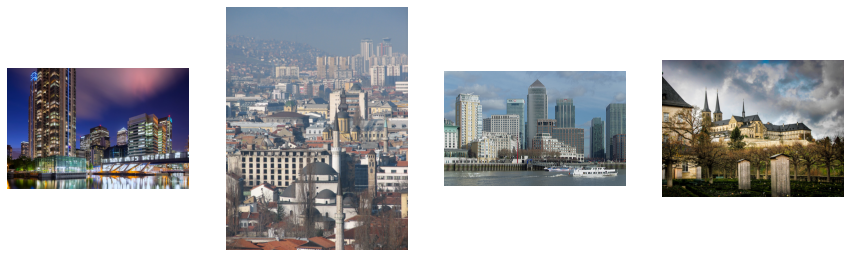

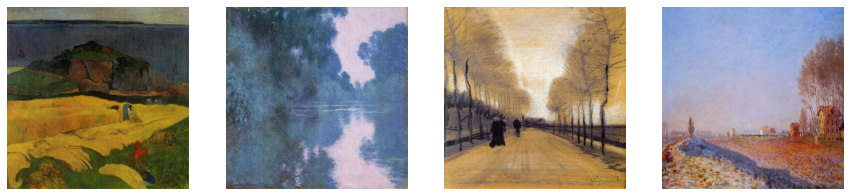

In [26]:
from PIL import ImageShow

plt.figure(figsize=(15,15))
for i, img in enumerate(pic_ds[0:4]):
    plt.subplot(1,4,i+1)
    plt.imshow(img)
    plt.axis('off')
plt.show()

plt.figure(figsize=(15,15))
for i, img in enumerate(paint_ds[0:4]):
    plt.subplot(1,4,i+1)
    plt.imshow(img)
    plt.axis('off')
    
plt.show()

In [27]:
pic_train_size = int(0.7 * PIC_DATASET_SIZE)
pic_test_size = int(0.15 * PIC_DATASET_SIZE)
pic_val_size = int(0.15 * PIC_DATASET_SIZE)

In [182]:
import random

# For resizing the images
IMG_HEIGHT = 256
IMG_WIDTH = 256

def resize(image):
    return image.resize((IMG_HEIGHT, IMG_WIDTH))


# I CANT FIGURE THIS OUT 
# normalizing the images to [-1, 1]
# def normalize(image):
#     return image.point(lambda i: (float(i)/127.5) - 1)

# def denormalize(image):
#     image = tf.cast(image, tf.float32)
#     image = (image * 0.5 + 0.5) * 255 # Range 0 to 1 and then to range 0..255
#     image = tf.cast(image, tf.int32)
#     return image

def random_crop(image, target_size): # assume square
    img_size = image.size
    x_max = img_size[0] - target_size
    y_max = img_size[1] - target_size

    random_x = random.randrange(0, x_max//2 + 1) * 2
    random_y = random.randrange(0, y_max//2 + 1) * 2

    area = (random_x, random_y, random_x + target_size, random_y + target_size)
    return image.crop(area)

def random_jitter(image): # idk if this is the best method
    # resizing to 400 x 400
    image = image.resize((400, 400))

    # randomly cropping to 256 x 256
    image = random_crop(image,256)

    # random mirroring
    if random.randint(0, 1):
        image = image.transpose(Image.Transpose.FLIP_LEFT_RIGHT)

    return image

def preprocess_image_train(image):
    image = resize(image)
    image = random_jitter(image)
    #image = normalize(image)
    return image

def preprocess_image_test(image):
    image = resize(image)
    #image = normalize(image)
    return image

In [ ]:
pic_train = [preprocess_image_train(img) for img in pic_ds]
pic_test = [preprocess_image_test(img) for img in pic_ds]
paint_train = 

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

In [ ]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)